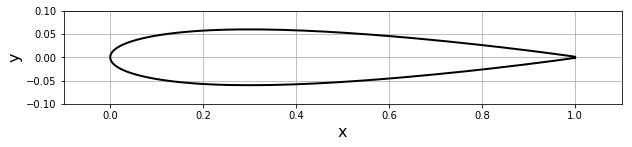

In [35]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import integrate
import numpy as np
import math


with open ('naca0012.dat', 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);



In [36]:
class Panel:

    def __init__(self,xa,ya,xb,yb):
        self.xa,self.ya = xa,ya
        self.xb,self.yb = xb,yb
        self.xc, self.yc = (xa + xb)/2, (ya+yb)/2
        self.length = np.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        if xb -xa <= 0.0:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + math.acos(-(yb -ya)/self.length)
        
        if self.beta <= math.pi:
            self.loc ='upper'
        else:
            self.loc ='lower'
        self.sigma =0.0
        self.vt =0.0
        self. cp =0.0
        

In [37]:
def define_panels(x,y,N=40):
    R = (x.max()-x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*np.cos(np.linspace(0.0,2*np.pi,N+1))
    
    x_ends = np.copy(x_circle)
    y_ends = np.empty_like(x_ends)
    
    x,y = np.append(x,x[0]),np.append(y,y[0])
    
    I=0
    for i in range(N):
        while I < len(x) -1:
            if (x[I]<=x_ends[i]<= x[I+1]) or (x[I+1]<=x_ends[i]<=x[I]):
                break
            else:
                I+=1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i]+b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N,dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i],y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels          

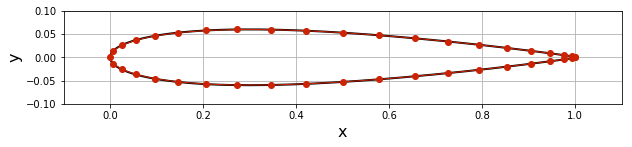

In [38]:
N = 40                           # number of panels
panels = define_panels(x, y, N)  # discretizes of the geometry into panels

# plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

In [39]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees --> radians

In [40]:

u_inf = 1.0                            # freestream spee
alpha = 0.0                            # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha) 

In [41]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [42]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   math.cos(p_i.beta),
                                                   math.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = np.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [43]:
A = build_matrix(panels)
b = build_rhs(panels,freestream)

In [44]:
sigma = np.linalg.solve(A,b)
for i, panel in enumerate(panels):
    panel.sigma =sigma[i]

In [45]:
def get_tangential_velocity(panels, freestream):
    N = len(panels)
    A =np.empty((N,N),dtype =float)
    np.fill_diagonal(A,0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/np.pi*integral(p_i.xc, p_i.yc, p_j,
                                            -math.sin(p_i.beta),
                                            math.cos(p_i.beta))
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                  for panel in panels])
    sigma =np.array([panel.sigma for panel in panels])
    vt = np.dot(A,sigma) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]
                

In [46]:
get_tangential_velocity(panels,freestream)

In [48]:
def get_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp =1.0 - (panel.vt/freestream.u_inf)**2

In [49]:
get_pressure_coefficient(panels,freestream)

In [50]:
voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [51]:
xtheo=np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


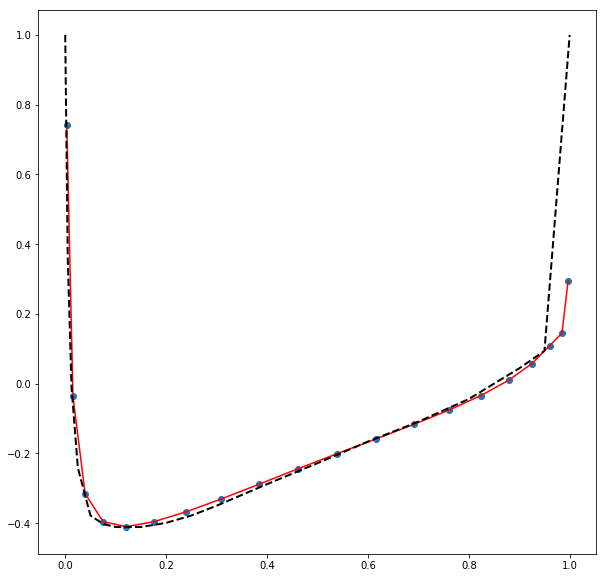

In [60]:
plt.figure(figsize=(10,10))
plt.plot([panel.xc for panel in panels if panel.loc =='upper'],
        [panel.cp for panel in panels if panel.loc =='upper'], label='upper',
        color='red')
plt.scatter([panel.xc for panel in panels if panel.loc == 'lower'],
        [panel.cp for panel in panels if panel.loc == 'lower'],label='lower')
plt.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)

In [63]:
def get_velocity_field(panels,freestream,X,Y):
    u = freestream.u_inf * math.cos(freestream.alpha)* np.ones_like(X,dtype=float)
    v = freestream.u_inf *math.sin(freestream.alpha)*np.ones_like(X,dtype=float)
    vec_integral =np.vectorize(integral)
    for panel in panels:
        u+= panels.sigma/(2.0*math.pi)*vec_integral(X,Y,panel,1.0,0.0)
        v+= panels.sigma/(2*np.pi)*vec_integral(X,Y,panel,0.0,1.0)
    return u,v


In [65]:
nx,ny =20,20
x_start, x_end = -1.0,2.0
y_start, y_end = -0.3,0.3
X,Y = np.meshgrid(np.linspace(x_start,x_end,nx),
                 np.linspace(y_start,y_end,ny))
u,v = get_velocity_field(panels,freestream,X,Y)

plt.streamplot(X,Y,u,v)

AttributeError: 'numpy.ndarray' object has no attribute 'sigma'